## Imports

In [ ]:
import numpy as np
import einops
import matplotlib
import matplotlib.pyplot as plt


from scipy.spatial import ckdtree
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

from shapely.geometry.polygon import Polygon
import shapely
from shapely import affinity

import importlib

: 

In [205]:
import bonds
import lattice
import utils
import plot_utils

In [206]:
bonds = importlib.reload(bonds)
lattice = importlib.reload(lattice)
utils = importlib.reload(utils)


## Set up lattice

### Triangular

In [207]:
# # lattice params for kagome lattice
# nx = 4
# ny = 3
# grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
#                'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 
#                'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
#                                  }
# mesh = lattice.create_grid_mesh(grid_params)
# BZ_kpoints = lattice.create_grid(grid_params)
# my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

In [208]:
# lattice params for triangular lattice
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0.,0.), 
               'unit_cell_bases':[np.array([0.,0.])] 
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

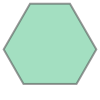

In [209]:
# Define the polygon for the cut
height = np.sqrt(3)/2
epsilon = 0.01 # to shift the boundary of the polygon slightly so that the region counts correct points within the boundary
polygon = Polygon([(3 - epsilon, 0 - epsilon), (7 + epsilon, 0 - epsilon), (8.5 + epsilon, 3 * height + epsilon), 
                   (6.5 + epsilon, 7 * height + epsilon), (3.5 - epsilon, 7 * height + epsilon), (1.5 - epsilon, 3 * height + epsilon)])
polygon

In [210]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

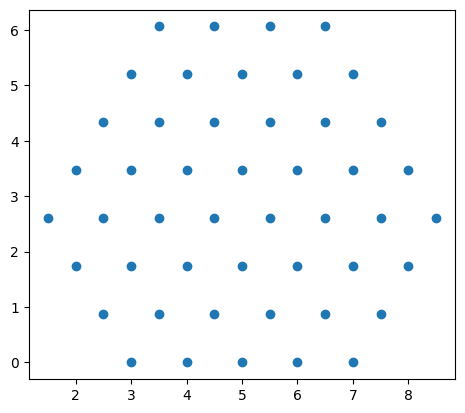

In [211]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=48 and $N_{\\rm bonds}=$120')

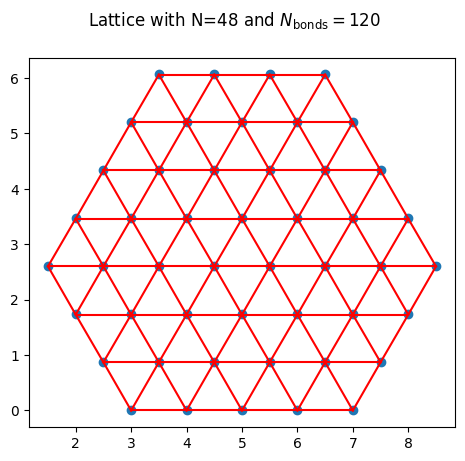

In [212]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [213]:
ListEB_comb = bonds.get_elementaryLoops((8, 8), 'triangular')
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

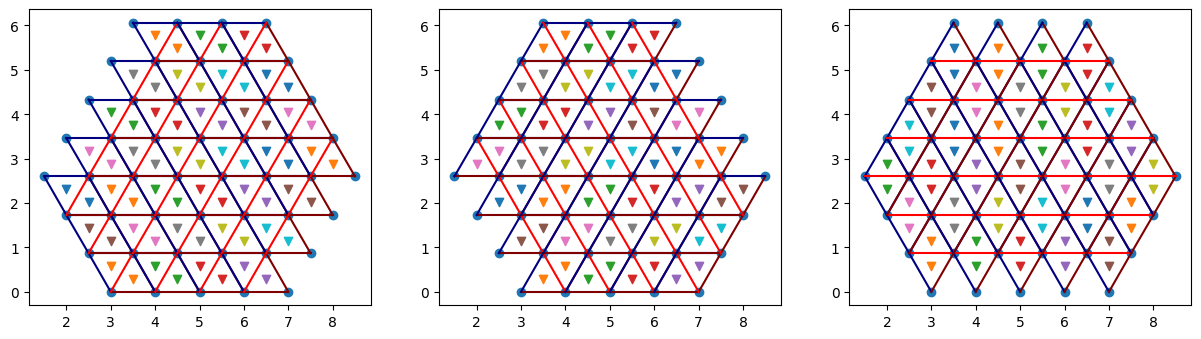

In [214]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

### Kagome

In [215]:
# lattice params for kagome lattice
nx = 6
ny = 6
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

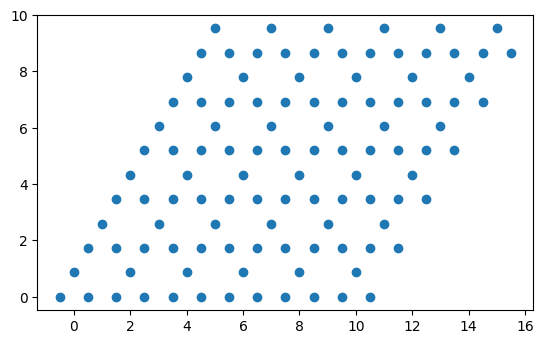

In [216]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

In [217]:
height = np.sqrt(3)/2
polygon = lattice.create_hexagon(5.1, 7, 5 * height)
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome', 
    polygon=polygon, 
)

ebSpecs = bonds.Bonds(
    polygon_ebs = [
        polygon, polygon, polygon, polygon, polygon, polygon
    ], 
    unit_cell_bases_ebs = [
        np.array([0, height]), 
        np.array([1.5, 0.]),
        np.array([0.5, 0.]),
        np.array([0., height]),
        np.array([-0.5, 0.]),
        np.array([0.5, 0.]),
    ]    
)

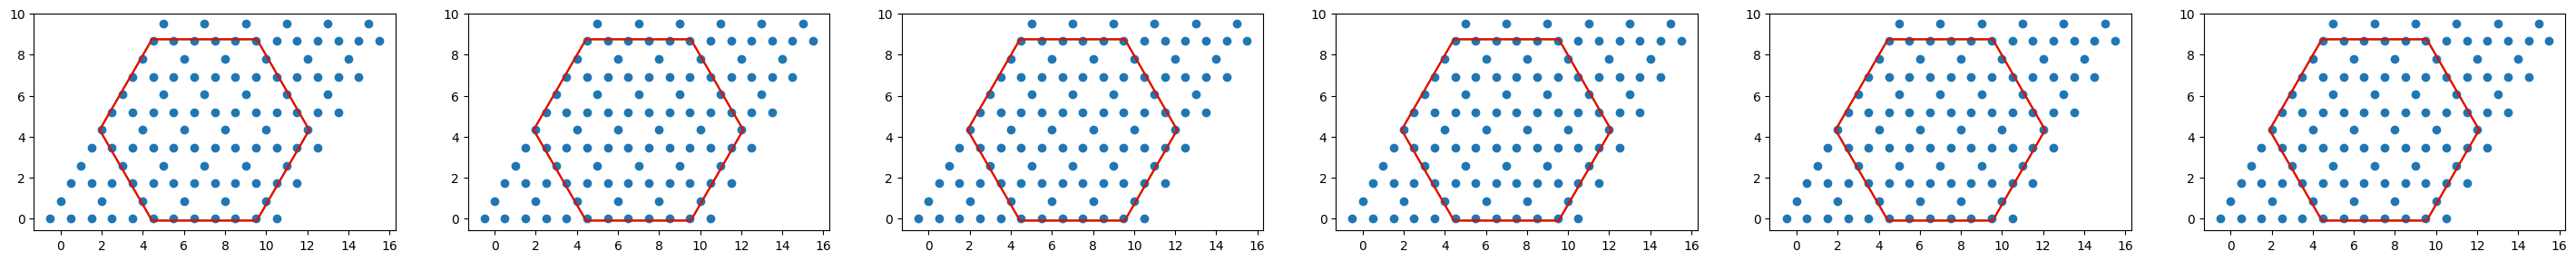

In [218]:

fig, axes = plt.subplots(1,6, figsize=(6 *6, 8))
for i, ax in enumerate(axes):
    ax = axes[i]
    my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")
    x,y = polygon.exterior.xy
    polygon2 = ebSpecs.polygon_ebs[i]
    x2,y2 = polygon2.exterior.xy
    ax.plot(x,y, c='g', label="cut boundary")
    ax.plot(x2,y2, c='r', label="cut boundary")

In [219]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

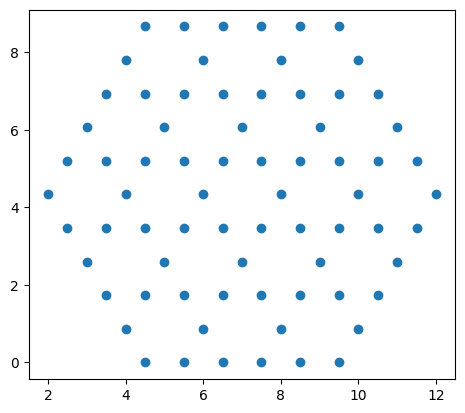

In [220]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=72 and $N_{\\rm bonds}=$126')

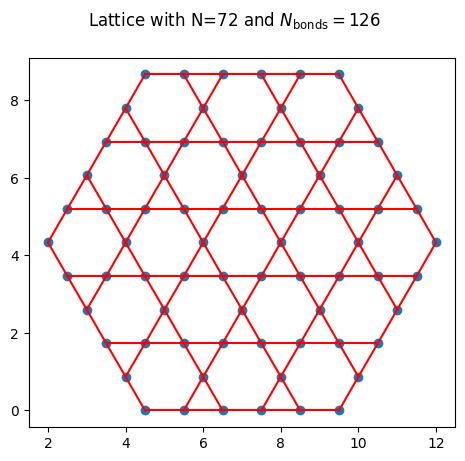

In [221]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [222]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs, ebSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

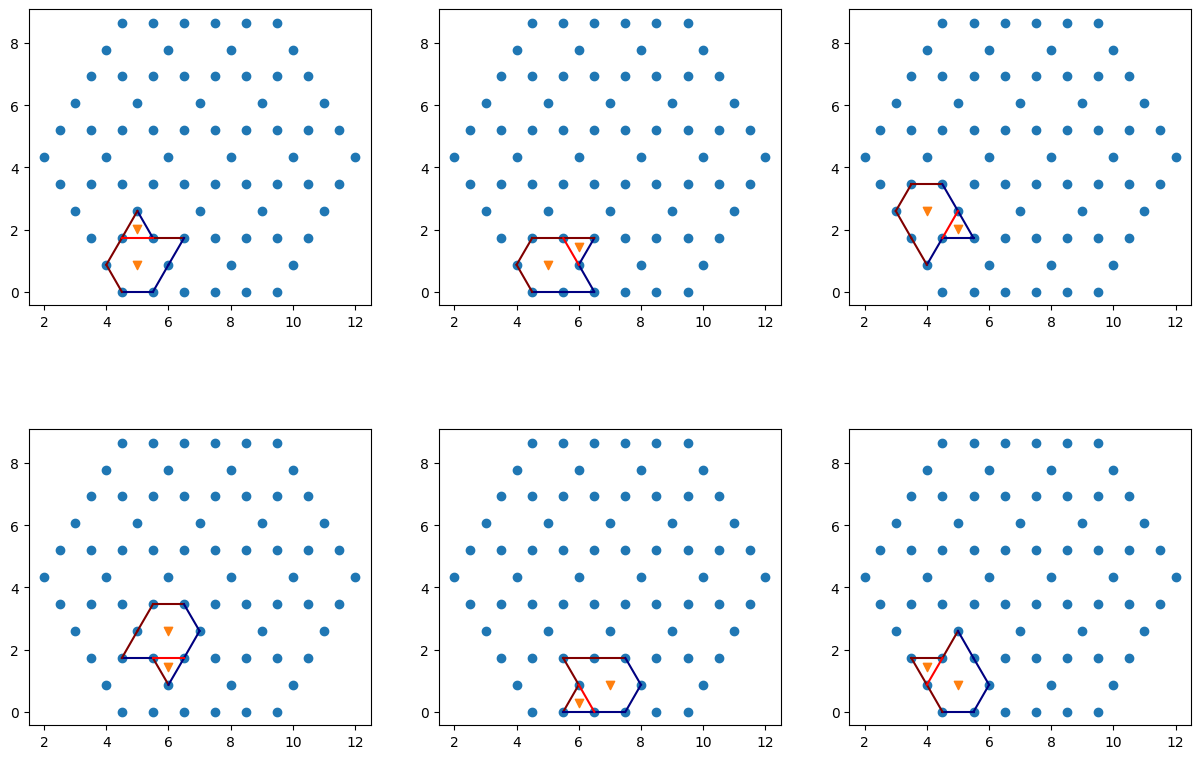

In [223]:
fig, axes = plt.subplots(2,3, figsize = (3 * 5, 5 * 2))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i // 3, i % 3]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs[:1]):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

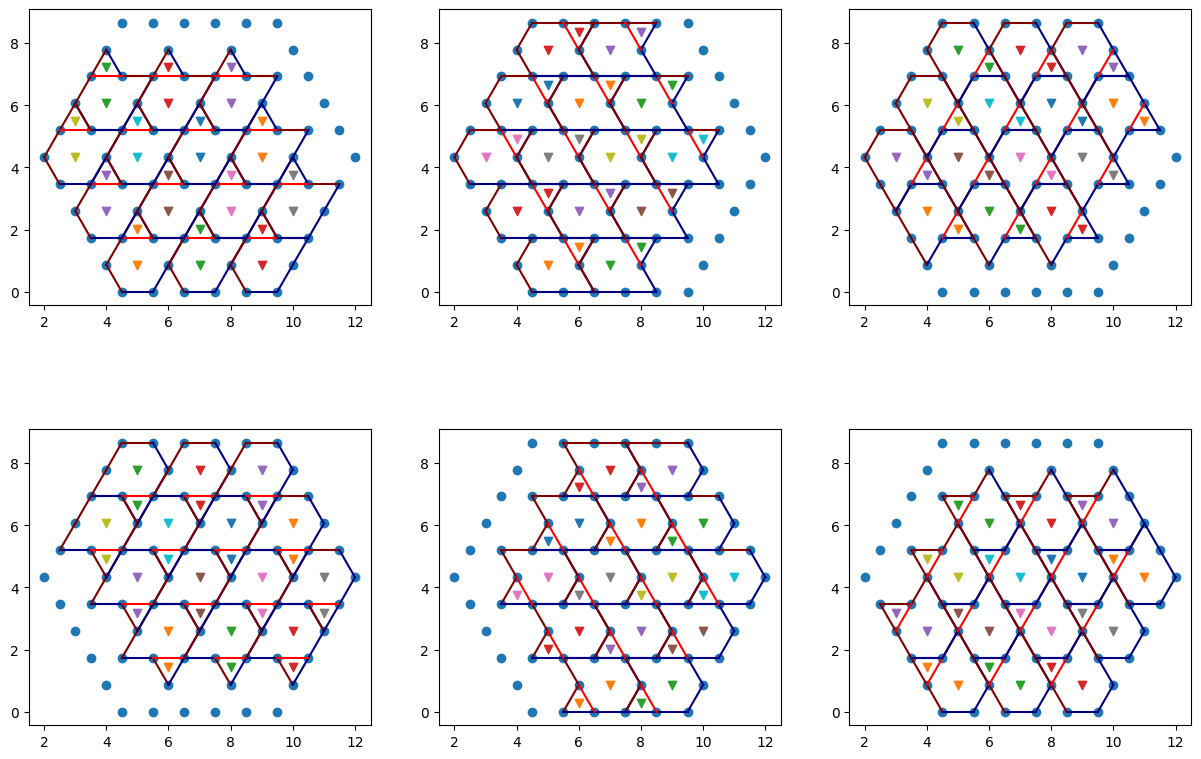

In [224]:
fig, axes = plt.subplots(2,3, figsize = (3 * 5, 5 * 2))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i // 3, i % 3]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

#### Saddle point 

In [239]:
bonds_dict = utils.build_dict_bonds(bonds_nn)

In [261]:
couplings = {'alpha':1, "beta":-3, "K":-2.5}
Q_init = np.ones(len(bonds_nn))
Q0 = 0.1
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

In [262]:
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), np.ones_like(Q_init))
results_gs = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_gs = minimize(energy_Q, Q_init)

`gtol` termination condition is satisfied.
Number of iterations: 13, function evaluations: 1016, CG iterations: 7, optimality: 4.37e-09, constraint violation: 0.00e+00, execution time:  2.6 s.


In [263]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-1.2367635797650145
True
`gtol` termination condition is satisfied.
1


array([0.99822367, 0.99822367, 0.99822362, 0.99822365, 0.99822367,
       0.99822367, 0.99822369, 0.99822369, 0.99822365, 0.99822362,
       0.99822365, 0.99822359, 0.99822362, 0.99822367, 0.99822362,
       0.99822375, 0.99822362, 0.99822361, 0.99822362, 0.99822359,
       0.99822367, 0.99822369, 0.99822366, 0.99822369, 0.99822367,
       0.99822367, 0.99822361, 0.99822362, 0.99822366, 0.99822362,
       0.99822362, 0.99822371, 0.99822362, 0.99822362, 0.99822362,
       0.99822362, 0.99822362, 0.99822362, 0.99822366, 0.99822369,
       0.99822365, 0.99822359, 0.99822367, 0.99822361, 0.99822363,
       0.99822365, 0.99822362, 0.99822371, 0.99822362, 0.99822362,
       0.99822362, 0.99822362, 0.99822362, 0.99822362, 0.99822362,
       0.99822375, 0.99822362, 0.99822361, 0.99822367, 0.99822367,
       0.99822367, 0.99822365, 0.99822372, 0.99822375, 0.99822367,
       0.99822362, 0.99822361, 0.99822362, 0.99822366, 0.99822362,
       0.99822372, 0.99822362, 0.99822359, 0.99822365, 0.99822

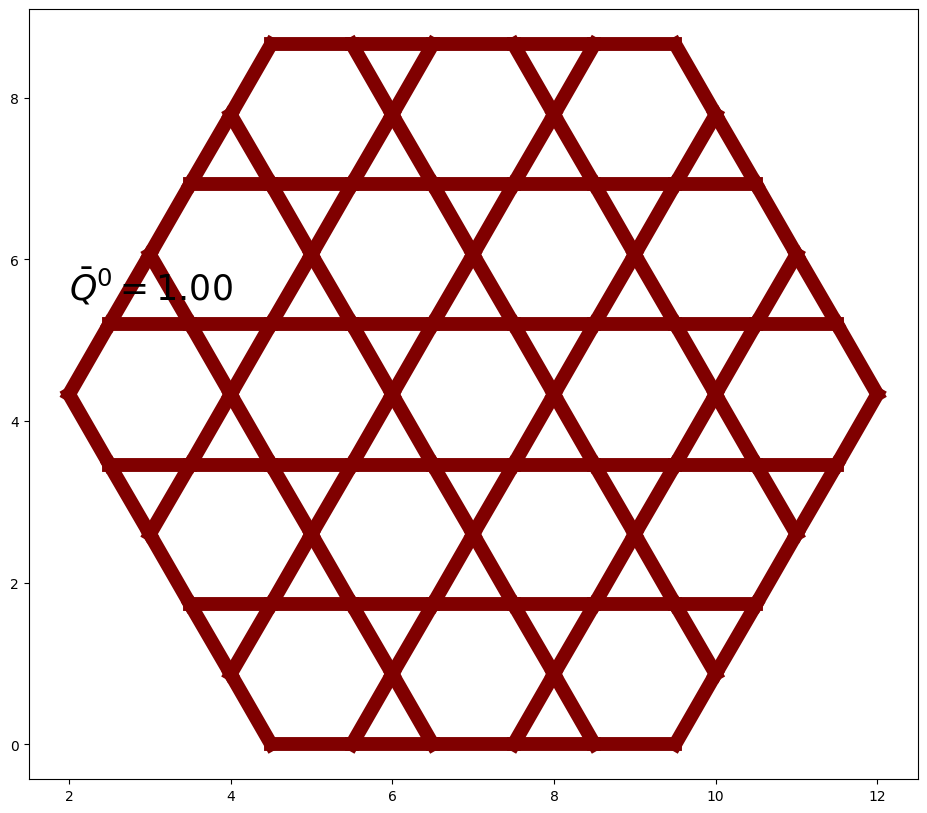

In [264]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_init), Q_init * results_gs['x'], c=colors[((np.sign(results_gs['x']) + 1)/2).astype(int)], p=10)
  ax.set_aspect("equal")
  ax.annotate(r"$\bar{Q}^0=$" + f"{np.mean(results_gs['x']):.2f}", (2., 5.5), size=25)
  # ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison


In [265]:

visonSpecs = bonds.Visons(
    v_pt=np.array([7, 5 * height]),
    visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
                 np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
              np.array([[8.5, 4. * height], [9.,  3 * height]]), 
              np.array([[9.,  3 * height], [9.5, 4 *height]]), 
              np.array([[10.5, 2 *height], [11, 3 * height]]),
              ]
)              
visonBonds_idx = []
Q_flip = Q_init
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

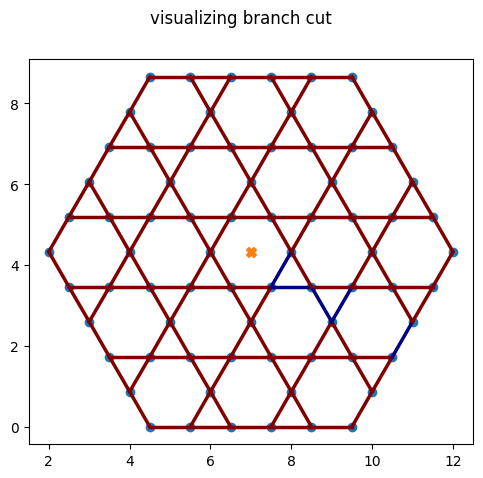

In [266]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [267]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = results_gs['x'] 
Q0 = 0.5
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init),  np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 1270, CG iterations: 13, optimality: 8.14e-09, constraint violation: 0.00e+00, execution time:  3.8 s.


In [268]:
energy_Q(Q_init)

-23.70763444677609

In [269]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-23.7605173427813
True
`gtol` termination condition is satisfied.
1


array([ 0.99994309,  0.99994309,  0.99974725,  0.99975317,  0.99975279,
        0.99974722,  0.99994276,  0.99993837,  0.99975279,  0.99974725,
        0.99975318,  0.99999516,  0.99999176,  0.99999518,  0.99999204,
        0.9997546 ,  0.99999147,  0.99977091,  0.99980503,  0.99999516,
        0.99975279,  0.99993885,  0.99977109,  0.99993837,  0.99974725,
        0.99994309,  0.99977052,  0.99980397,  0.99975469,  0.99999134,
        0.99978148,  0.99974623,  0.99978157,  0.99974625, -0.99978144,
        0.99980439, -0.99980484,  0.99978143,  0.9997711 ,  0.99993849,
        0.99975279,  0.99999504,  0.99993849,  0.99977085,  0.99999469,
        0.99975279,  0.99980451,  0.99978191,  0.99978169,  0.99980484,
        0.99974625,  0.99978158,  0.99974635,  0.99978156,  0.9998033 ,
        0.99977056,  0.99999155,  0.99975468,  0.99993864,  0.99994271,
        0.99974722,  0.99975279,  0.99999574,  0.99977056,  0.99993872,
        0.99999147,  0.99975469,  0.9998044 ,  0.99977111,  0.99

In [270]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

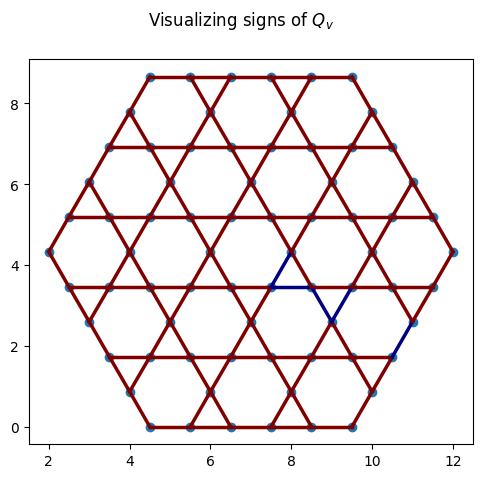

In [271]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [272]:
Qv_results - Q0_results

array([ 0.00171941,  0.00171942,  0.00152363,  0.00152952,  0.00152912,
        0.00152356,  0.00171907,  0.00171468,  0.00152914,  0.00152363,
        0.00152953,  0.00177158,  0.00176814,  0.00177151,  0.00176843,
        0.00153085,  0.00176786,  0.0015473 ,  0.00158141,  0.00177158,
        0.00152912,  0.00171516,  0.00154743,  0.00171468,  0.00152358,
        0.00171942,  0.0015469 ,  0.00158035,  0.00153103,  0.00176773,
        0.00155786,  0.00152252,  0.00155796,  0.00152263, -0.00155782,
        0.00158078, -0.00158122,  0.00155782,  0.00154744,  0.0017148 ,
        0.00152914,  0.00177145,  0.00171481,  0.00154724,  0.00177106,
        0.00152914,  0.0015809 ,  0.00155821,  0.00155807,  0.00158122,
        0.00152263,  0.00155796,  0.00152273,  0.00155794,  0.00157969,
        0.00154681,  0.00176794,  0.00153106,  0.00171496,  0.00171904,
        0.00152356,  0.00152914,  0.00177202,  0.00154681,  0.00171504,
        0.00176785,  0.00153107,  0.00158078,  0.00154745,  0.00

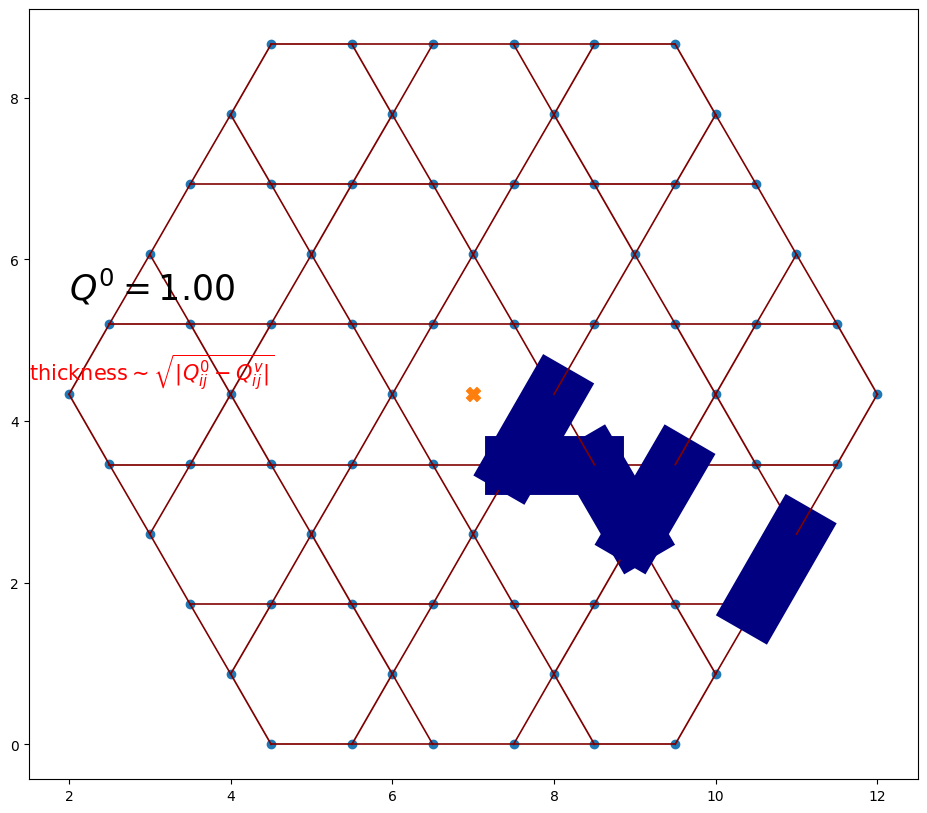

In [273]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

### Kagome bow tie

In [ ]:
# lattice params for kagome lattice
nx = 6
ny = 6
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 
               'a1':np.array([2,0]), 'a2':np.array([1, np.sqrt(3)]), 'O':(0., 0.),
               'unit_cell_bases':[np.array([1/2, 0]), np.array([-1/2, 0]), np.array([0, np.sqrt(3)/2.])]  
                                 }
mesh = lattice.create_grid_mesh(grid_params)
BZ_kpoints = lattice.create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

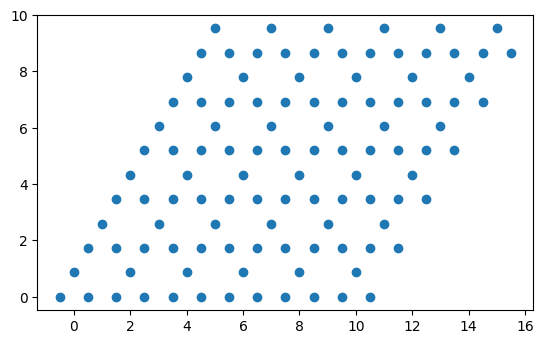

In [ ]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

In [ ]:
height = np.sqrt(3)/2
polygon = lattice.create_hexagon(5.1, 7, 5 * height)
LatticeSpecs = lattice.Lattice(
    a1=np.array([2,0]),
    a2=np.array([1, np.sqrt(3)]),
    unit_cell_bases=[np.array([0.0, 0.0])], 
    lattice_type='kagome', 
    polygon=polygon, 
)

ebSpecs = bonds.Bonds(
    polygon_ebs = [
        polygon, polygon, polygon, polygon, polygon, polygon
    ], 
    unit_cell_bases_ebs = [
        np.array([0, height]), 
        np.array([1.5, 0.]),
        np.array([0.5, 0.]),
        np.array([0., height]),
        np.array([-0.5, 0.]),
        np.array([0.5, 0.]),
    ]    
)

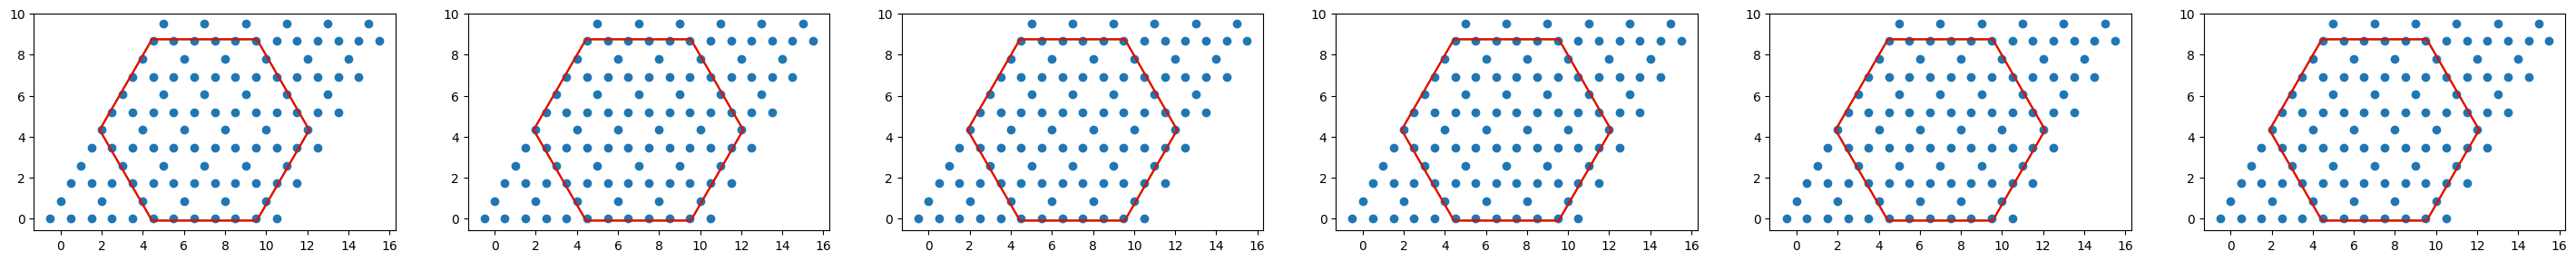

In [ ]:

fig, axes = plt.subplots(1,6, figsize=(6 *6, 8))
for i, ax in enumerate(axes):
    ax = axes[i]
    my_x, my_y = lattice.convert_to_XY(BZ_kpoints)
    ax.scatter(my_x, my_y)
    ax.set_aspect("equal")
    x,y = polygon.exterior.xy
    polygon2 = ebSpecs.polygon_ebs[i]
    x2,y2 = polygon2.exterior.xy
    ax.plot(x,y, c='g', label="cut boundary")
    ax.plot(x2,y2, c='r', label="cut boundary")

In [ ]:
BZ_kpoints_cut = lattice.get_contained_pts_poly(BZ_kpoints, polygon)

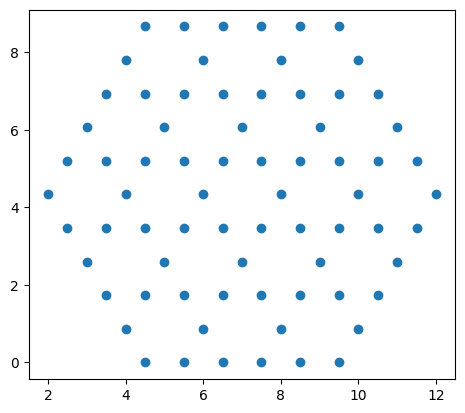

In [ ]:
fig, ax = plt.subplots(1,1)
my_x, my_y = lattice.convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")

Text(0.5, 0.98, 'Lattice with N=72 and $N_{\\rm bonds}=$126')

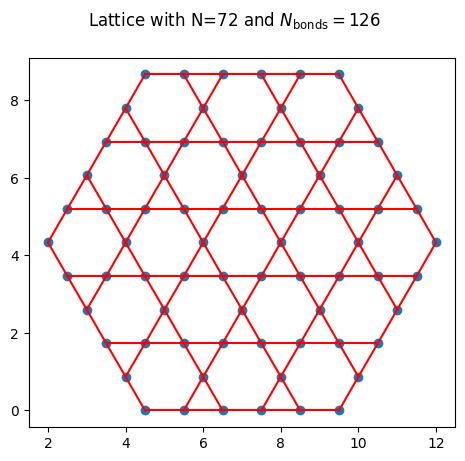

In [ ]:
bonds_nn = bonds._find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
plot_utils._plot_v_bonds(ax, bonds_nn, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds_nn.shape[0]}")


In [ ]:
ListEB_comb = bonds.get_elementaryLoops((nx, ny), 'na', LatticeSpecs, ebSpecs)
ListEBs = sum(ListEB_comb, [])
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

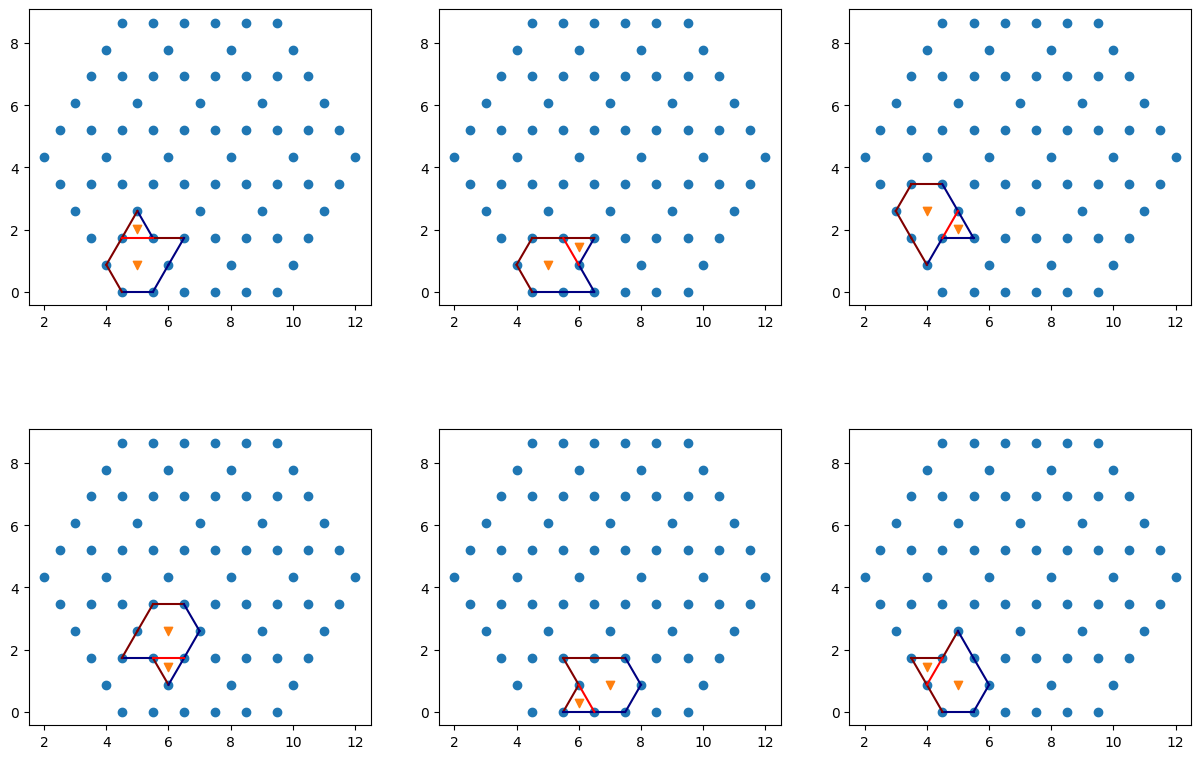

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (3 * 5, 5 * 2))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i // 3, i % 3]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs[:1]):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

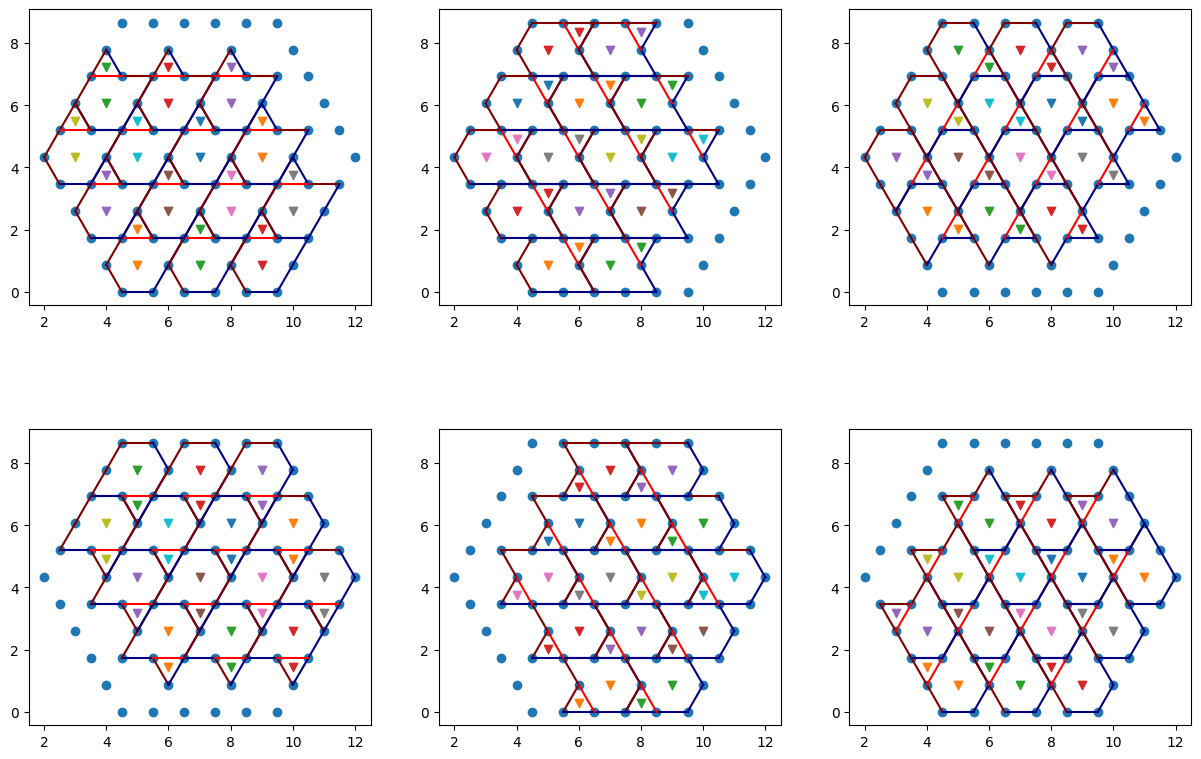

In [ ]:
fig, axes = plt.subplots(2,3, figsize = (3 * 5, 5 * 2))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i // 3, i % 3]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    # print(bd_vs.shape)
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    plot_utils._plot_v_bonds(ax, bd_vs, c=c)
    plot_utils._plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

#### Saddle point 

In [ ]:
bonds_dict = utils.build_dict_bonds(bonds_nn)

In [ ]:
couplings = {'alpha':1, "beta":-3, "K":-2.5}
Q_init = np.ones(len(bonds_nn))
Q0 = 0.1
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

In [ ]:
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), np.ones_like(Q_init))
results_gs = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_gs = minimize(energy_Q, Q_init)

`gtol` termination condition is satisfied.
Number of iterations: 13, function evaluations: 1016, CG iterations: 7, optimality: 4.37e-09, constraint violation: 0.00e+00, execution time:  2.6 s.


In [ ]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-1.2367635797650145
True
`gtol` termination condition is satisfied.
1


array([0.99822367, 0.99822367, 0.99822362, 0.99822365, 0.99822367,
       0.99822367, 0.99822369, 0.99822369, 0.99822365, 0.99822362,
       0.99822365, 0.99822359, 0.99822362, 0.99822367, 0.99822362,
       0.99822375, 0.99822362, 0.99822361, 0.99822362, 0.99822359,
       0.99822367, 0.99822369, 0.99822366, 0.99822369, 0.99822367,
       0.99822367, 0.99822361, 0.99822362, 0.99822366, 0.99822362,
       0.99822362, 0.99822371, 0.99822362, 0.99822362, 0.99822362,
       0.99822362, 0.99822362, 0.99822362, 0.99822366, 0.99822369,
       0.99822365, 0.99822359, 0.99822367, 0.99822361, 0.99822363,
       0.99822365, 0.99822362, 0.99822371, 0.99822362, 0.99822362,
       0.99822362, 0.99822362, 0.99822362, 0.99822362, 0.99822362,
       0.99822375, 0.99822362, 0.99822361, 0.99822367, 0.99822367,
       0.99822367, 0.99822365, 0.99822372, 0.99822375, 0.99822367,
       0.99822362, 0.99822361, 0.99822362, 0.99822366, 0.99822362,
       0.99822372, 0.99822362, 0.99822359, 0.99822365, 0.99822

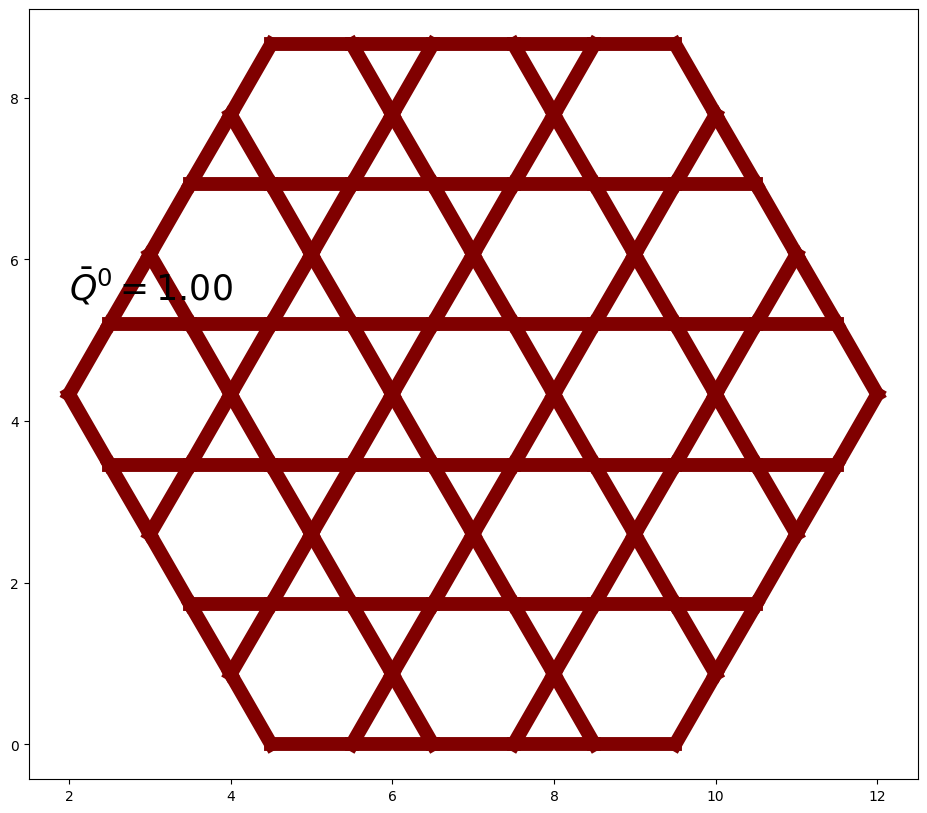

In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_init), Q_init * results_gs['x'], c=colors[((np.sign(results_gs['x']) + 1)/2).astype(int)], p=10)
  ax.set_aspect("equal")
  ax.annotate(r"$\bar{Q}^0=$" + f"{np.mean(results_gs['x']):.2f}", (2., 5.5), size=25)
  # ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

#### vison


In [ ]:

visonSpecs = bonds.Visons(
    v_pt=np.array([7, 5 * height]),
    visonBonds_vs = [np.array([[7.5, 4 * height], [8., 5 * height]]),
                 np.array([[7.5, 4 * height], [8.5, 4. * height]]), 
              np.array([[8.5, 4. * height], [9.,  3 * height]]), 
              np.array([[9.,  3 * height], [9.5, 4 *height]]), 
              np.array([[10.5, 2 *height], [11, 3 * height]]),
              ]
)              
visonBonds_idx = []
Q_flip = Q_init
for bd_v in visonSpecs.visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

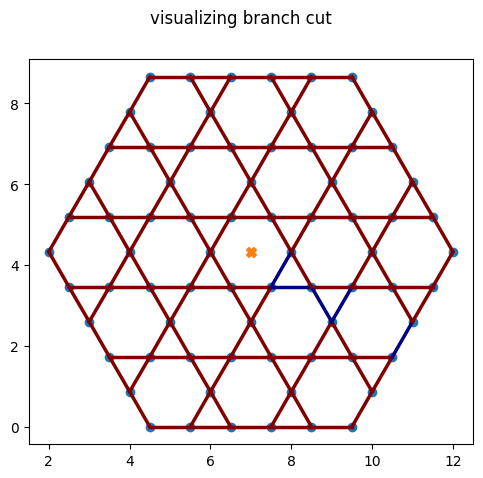

In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
Q_flip = Q_init
# print(Q_init)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=50.)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
  plt.suptitle("visualizing branch cut")

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = results_gs['x'] 
Q0 = 0.5
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: utils.get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init),  np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`gtol` termination condition is satisfied.
Number of iterations: 15, function evaluations: 1270, CG iterations: 13, optimality: 8.14e-09, constraint violation: 0.00e+00, execution time:  3.8 s.


In [ ]:
energy_Q(Q_init)

-23.70763444677609

In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-23.7605173427813
True
`gtol` termination condition is satisfied.
1


array([ 0.99994309,  0.99994309,  0.99974725,  0.99975317,  0.99975279,
        0.99974722,  0.99994276,  0.99993837,  0.99975279,  0.99974725,
        0.99975318,  0.99999516,  0.99999176,  0.99999518,  0.99999204,
        0.9997546 ,  0.99999147,  0.99977091,  0.99980503,  0.99999516,
        0.99975279,  0.99993885,  0.99977109,  0.99993837,  0.99974725,
        0.99994309,  0.99977052,  0.99980397,  0.99975469,  0.99999134,
        0.99978148,  0.99974623,  0.99978157,  0.99974625, -0.99978144,
        0.99980439, -0.99980484,  0.99978143,  0.9997711 ,  0.99993849,
        0.99975279,  0.99999504,  0.99993849,  0.99977085,  0.99999469,
        0.99975279,  0.99980451,  0.99978191,  0.99978169,  0.99980484,
        0.99974625,  0.99978158,  0.99974635,  0.99978156,  0.9998033 ,
        0.99977056,  0.99999155,  0.99975468,  0.99993864,  0.99994271,
        0.99974722,  0.99975279,  0.99999574,  0.99977056,  0.99993872,
        0.99999147,  0.99975469,  0.9998044 ,  0.99977111,  0.99

In [ ]:
Q0_results = results_gs['x']
Qv_results = results_vison['x']

Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

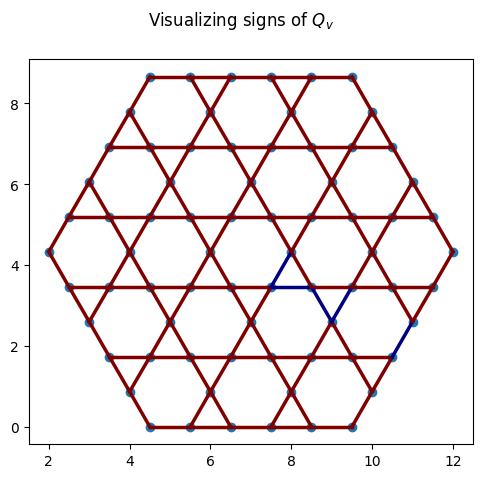

In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [ ]:
Qv_results - Q0_results

array([ 0.00171941,  0.00171942,  0.00152363,  0.00152952,  0.00152912,
        0.00152356,  0.00171907,  0.00171468,  0.00152914,  0.00152363,
        0.00152953,  0.00177158,  0.00176814,  0.00177151,  0.00176843,
        0.00153085,  0.00176786,  0.0015473 ,  0.00158141,  0.00177158,
        0.00152912,  0.00171516,  0.00154743,  0.00171468,  0.00152358,
        0.00171942,  0.0015469 ,  0.00158035,  0.00153103,  0.00176773,
        0.00155786,  0.00152252,  0.00155796,  0.00152263, -0.00155782,
        0.00158078, -0.00158122,  0.00155782,  0.00154744,  0.0017148 ,
        0.00152914,  0.00177145,  0.00171481,  0.00154724,  0.00177106,
        0.00152914,  0.0015809 ,  0.00155821,  0.00155807,  0.00158122,
        0.00152263,  0.00155796,  0.00152273,  0.00155794,  0.00157969,
        0.00154681,  0.00176794,  0.00153106,  0.00171496,  0.00171904,
        0.00152356,  0.00152914,  0.00177202,  0.00154681,  0.00171504,
        0.00176785,  0.00153107,  0.00158078,  0.00154745,  0.00

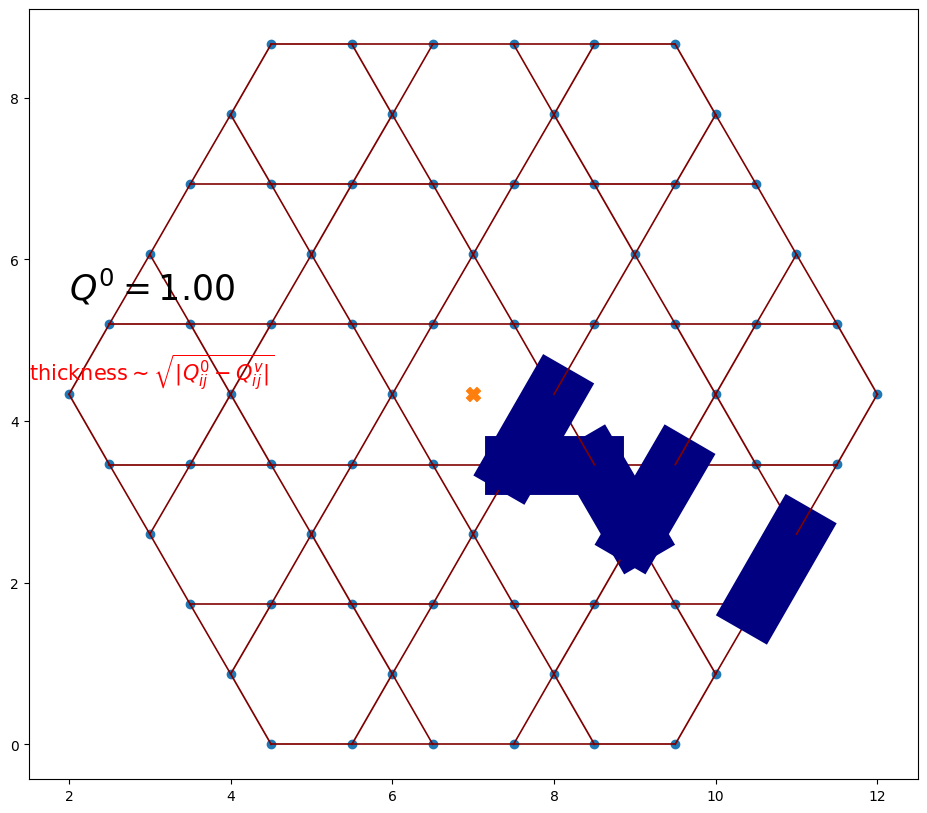

In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds_nn]:
  plot_utils._plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.scatter(*visonSpecs.v_pt, marker="X", s=100)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{|Q^0_{ij} - Q^v_{ij}|}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')